https://towardsdatascience.com/5-techniques-to-work-with-imbalanced-data-in-machine-learning-80836d45d30c

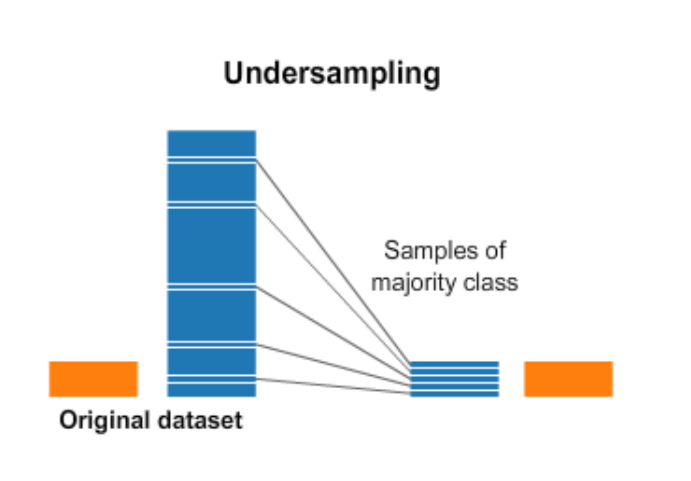

In [35]:
!pip install scikit-optimize

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.3/100.3 KB 3.6 MB/s eta 0:00:00


/usr/local/lib/python3.8/dist-packages/google/colab/_pip.py:83: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.8/dist-packages/pyaml-21.10.1.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):
/usr/local/lib/python3.8/dist-packages/google/colab/_pip.py:83: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.8/dist-packages/scikit_optimize-0.9.0.dist-info/top_level.txt' mode='r' encoding='UTF-8'>
  for line in open(toplevel):


In [2]:
import pandas as pd
import numpy as np

In [3]:
df = pd.read_excel('/content/df_main_all_features_26jan.xlsx')   
df = df.set_index('ID')
df.age = df.age.fillna(df.age.mean())
df = df.dropna()
df.head(1)

,sex,age,education_lvl,education_years,depression,tds,id,chroma_cens,chroma_cqt,chroma_stft,...,spectral_flatness_avg,spectral_flatness_std,spectral_rolloff_avg,spectral_rolloff_std,tempogram_avg,tempogram_std,tonnetz_avg,tonnetz_std,zero_crossing_rate_avg,zero_crossing_rate_std
ID,,,,,,,,,,,,,,,,,,,,,
PD-003,1,17.0,0,10,0,0,PD-003,[[1.11672273e-01 1.17649218e-01 1.24970686e-01...,[[0.19607635 0.21339749 0.24352823 ... 0.34575...,[[0.7175596 0.799478 0.88265824 ... 0.18122...,...,0.010274,0.021415,3650.894661,1749.280332,0.213538,0.237341,0.022909,0.091652,0.084568,0.081494


In [4]:
df.tds.value_counts()

0    150
1     16
2      3
Name: tds, dtype: int64

In [5]:
df["tds"] = df.tds.replace({2: 1}) #there are only 3 people in class 2, so it is ok to replace 2 to 1, so that we have binary class-ion
df.tds.value_counts()

0    150
1     19
Name: tds, dtype: int64

**Balancing the dataset**

In [6]:
df_sample_clean = df.drop(['age', 'education_lvl', 'education_years', 'sex', 'depression', 'chroma_cens', 'chroma_cqt', 'id', 'chroma_stft',
    'melspectrogram', 'mfcc', 'poly_features', 'rmfourier_tempograms', 'rms', 'spectral_bandwidth', 'spectral_centroid',
    'spectral_contrast', 'spectral_flatness', 'spectral_rolloff', 'tempogram', 'tonnetz', 'zero_crossing_rate', 'mfcc_avg',
    'rms_avg'], axis=1)

In [26]:
X = df_sample_clean.drop(['tds'], axis=1) # Features , 'rmfourier_tempograms_avg'
y = df_sample_clean.tds # Target variable

In [27]:
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import EditedNearestNeighbours
from matplotlib import pyplot
from numpy import where

# define the undersampling method
undersample = EditedNearestNeighbours(n_neighbors=40)

# transform the dataset
X, y = undersample.fit_resample(X, y)

# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({0: 19, 1: 19})


**Logreg all features**

In [28]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=16)

In [29]:
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

parameters = {
    'penalty' : ['l1','l2'], 
    'C'       : np.logspace(-3,3,7),
    'solver'  : ['newton-cg', 'lbfgs', 'liblinear'],
}

logreg = LogisticRegression()
clf = GridSearchCV(logreg,                    # model
                   param_grid = parameters,   # hyperparameters
                   scoring='accuracy',        # metric for scoring
                   cv=10)  
          
clf.fit(X_train,y_train)

print("Tuned Hyperparameters :", clf.best_params_)
print("Accuracy :",clf.best_score_)

Tuned Hyperparameters : {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
Accuracy : 0.9


In [30]:
warnings.filterwarnings('default')

In [31]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression(solver='lbfgs', max_iter=6000, penalty = 'l2', C=0.001) #, class_weight = 'balanced' 'C': 0.1,  'penalty': 'l2',  'solver': 'liblinear'
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [32]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

print(classification_report(y_test,y_pred))
val_acc = accuracy_score(y_pred, y_test)
print(val_acc)

              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.88      1.00      0.93         7

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.95      0.94      0.94        16

0.9375


In [33]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
scoring = ['recall', 'accuracy', 'f1']
scores = cross_validate(logreg, X, y, scoring=scoring)
scores

{'fit_time': array([0.09267139, 0.02035332, 0.11725616, 0.0863204 , 0.01687694]),
 'score_time': array([0.0034616 , 0.00343299, 0.00364733, 0.00335693, 0.00337315]),
 'test_recall': array([0.75      , 0.75      , 1.        , 0.66666667, 1.        ]),
 'test_accuracy': array([0.875     , 0.875     , 0.875     , 0.85714286, 1.        ]),
 'test_f1': array([0.85714286, 0.85714286, 0.88888889, 0.8       , 1.        ])}

**Random forest all features**

In [39]:
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

warnings.filterwarnings('ignore')

opt = BayesSearchCV(
    RandomForestClassifier(class_weight = "balanced"),
    {
        'n_estimators':  (100, 1000),
        'max_depth': (10, 100)
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))
print("best_params: %s" % opt.best_params_)

val. score: 0.8571428571428571
test score: 0.9375
best_params: OrderedDict([('max_depth', 43), ('n_estimators', 961)])


In [38]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=607, 
                             class_weight = "balanced",
                             max_depth = 35)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.88      1.00      0.93         7

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.95      0.94      0.94        16



In [40]:
cross_validate(rfc, X, y, scoring=scoring)

{'fit_time': array([1.79318619, 1.79626584, 1.60570288, 1.21559715, 0.72160339]),
 'score_time': array([0.13184524, 0.18622541, 0.12950087, 0.06189227, 0.08582568]),
 'test_recall': array([0.5 , 0.75, 1.  , 1.  , 1.  ]),
 'test_accuracy': array([0.75      , 0.875     , 0.875     , 0.85714286, 0.85714286]),
 'test_f1': array([0.66666667, 0.85714286, 0.88888889, 0.85714286, 0.88888889])}

**Support Vector Machine all features**

In [41]:
from skopt import BayesSearchCV
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

#https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html
opt = BayesSearchCV(
    SVC(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8), 
        'kernel': ['linear', 'poly', 'rbf'], 
    },
    n_iter=32,
    cv=3
)

opt.fit(X_train, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_test, y_test))

val. score: 0.9523809523809524
test score: 0.8125


In [42]:
opt.best_params_

OrderedDict([('C', 1.568704052067848e-06),
             ('degree', 7),
             ('gamma', 0.003965181983160825),
             ('kernel', 'linear')])

In [43]:
from sklearn import svm

clf = svm.SVC(C = 1.568704052067848e-06, degree = 7, gamma = 0.003965181983160825, kernel = 'linear')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

In [44]:
print(classification_report(y_test,y_pred))
val_acc = accuracy_score(y_pred, y_test)
print(val_acc)

              precision    recall  f1-score   support

           0       0.75      1.00      0.86         9
           1       1.00      0.57      0.73         7

    accuracy                           0.81        16
   macro avg       0.88      0.79      0.79        16
weighted avg       0.86      0.81      0.80        16

0.8125


In [45]:
cross_validate(clf, X, y, scoring=scoring)

{'fit_time': array([0.00458217, 0.00346565, 0.00212097, 0.00201941, 0.00196052]),
 'score_time': array([0.00561357, 0.00326133, 0.00295615, 0.00294495, 0.00296116]),
 'test_recall': array([0.5       , 0.75      , 1.        , 0.66666667, 0.75      ]),
 'test_accuracy': array([0.75      , 0.875     , 1.        , 0.85714286, 0.85714286]),
 'test_f1': array([0.66666667, 0.85714286, 1.        , 0.8       , 0.85714286])}

**MLP all features**

In [46]:
from sklearn.datasets import load_iris
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [47]:
sc_X = StandardScaler()
X_trainscaled=sc_X.fit_transform(X_train)
X_testscaled=sc_X.transform(X_test)

In [48]:
from skopt import BayesSearchCV
from sklearn.datasets import load_digits

#https://scikit-optimize.github.io/stable/auto_examples/sklearn-gridsearchcv-replacement.html
opt = BayesSearchCV(
    MLPClassifier(),
    {
        'activation': ['identity', 'logistic', 'tanh', 'relu'],
        'random_state': [1, 2, 3],
    },
    n_iter=32,
    cv=3
)

opt.fit(X_trainscaled, y_train)

print("val. score: %s" % opt.best_score_)
print("test score: %s" % opt.score(X_testscaled, y_test))

val. score: 0.9047619047619048
test score: 0.875


In [49]:
opt.best_params_

OrderedDict([('activation', 'relu'), ('random_state', 1)])

In [50]:
clf = MLPClassifier(hidden_layer_sizes=(256,128,64,32),activation="relu",random_state=1).fit(X_trainscaled, y_train)
y_pred=clf.predict(X_testscaled)
print(clf.score(X_testscaled, y_test))

0.8125


In [51]:
print(classification_report(y_test,y_pred))
val_acc = accuracy_score(y_pred, y_test)
print(val_acc)

              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.75      0.86      0.80         7

    accuracy                           0.81        16
   macro avg       0.81      0.82      0.81        16
weighted avg       0.82      0.81      0.81        16

0.8125


**Lets clean our feature-list according to the chart**

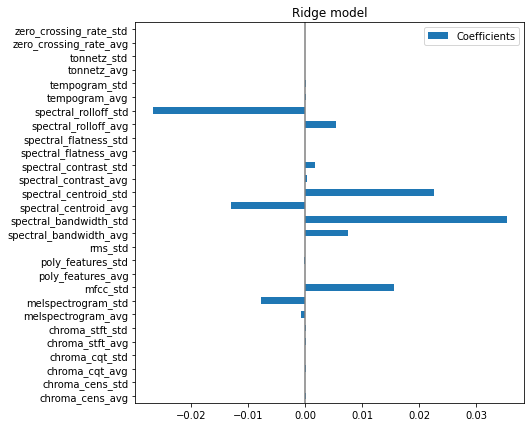

In [52]:
import matplotlib.pyplot as plt

coefs = pd.DataFrame(
   logreg.coef_.T,
   columns=['Coefficients'], index=X_train.columns
)

coefs.plot(kind='barh', figsize=(9, 7))
plt.title('Ridge model')
plt.axvline(x=0, color='.5')
plt.subplots_adjust(left=.3)

The picture for upsampling is different and coefficients for the upsampled model are not that small

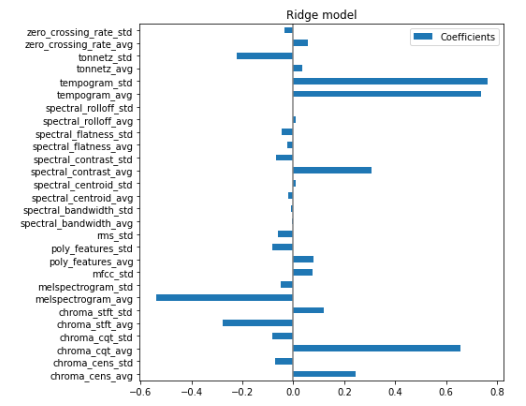

In [53]:
coefs.apply(lambda x: abs(x)).sort_values(by='Coefficients', ascending=False).head(11)

,Coefficients
spectral_bandwidth_std,0.035300
spectral_rolloff_std,0.026687
spectral_centroid_std,0.022590
mfcc_std,0.015483
spectral_centroid_avg,0.012974
melspectrogram_std,0.007826
spectral_bandwidth_avg,0.007558
spectral_rolloff_avg,0.005383
spectral_contrast_std,0.001642
melspectrogram_avg,0.000840


**Random forest with cleaned features**

Text(0.5, 0, 'Random Forest Feature Importance')

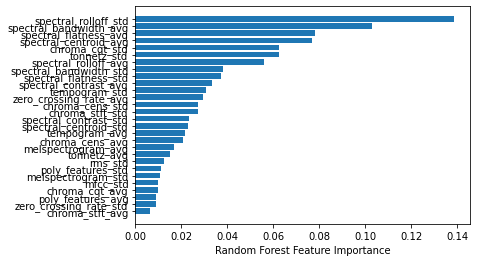

In [54]:
from sklearn.inspection import permutation_importance
sorted_idx = rfc.feature_importances_.argsort()
feature_names = [f"feature {i}" for i in range(X.shape[1])]
plt.barh(X.columns[sorted_idx], rfc.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")

In [55]:
X.columns[sorted_idx][15:]

Index(['chroma_cens_std', 'zero_crossing_rate_avg', 'tempogram_std',
       'spectral_contrast_avg', 'spectral_flatness_std',
       'spectral_bandwidth_std', 'spectral_rolloff_avg', 'tonnetz_std',
       'chroma_cqt_std', 'spectral_centroid_avg', 'spectral_flatness_avg',
       'spectral_bandwidth_avg', 'spectral_rolloff_std'],
      dtype='object')

In [61]:
rfc_feature_cols = X.columns[sorted_idx][15:]
rfc_X = df_sample_clean[rfc_feature_cols]
y = df_sample_clean.tds # Target variable

rfc_X, y = undersample.fit_resample(rfc_X, y)

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(rfc_X, y, test_size=0.4, random_state=16)

In [63]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier(n_estimators=100)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

In [64]:
print(classification_report(y_test,y_pred))
val_acc = accuracy_score(y_pred, y_test)
print(val_acc)

              precision    recall  f1-score   support

           0       0.89      0.89      0.89         9
           1       0.86      0.86      0.86         7

    accuracy                           0.88        16
   macro avg       0.87      0.87      0.87        16
weighted avg       0.88      0.88      0.88        16

0.875
